In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so
from pathlib import Path
from scipy import stats
from functools import partial
from itertools import combinations

In [2]:
[f.name for f in Path('../datasets').glob('*.*')]

['metadata.txt', 'test.csv', 'train.csv']

In [3]:
pd.set_option('display.max_columns', 80)

# Loading df

In [4]:
dummied_cols = ['MSSubClass', 'OverallQual', 'OverallCond']
date_frag_cols = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold', 'MoSold']

In [5]:
na_fill_mapping = {
    'Alley': 'NAcc',
    'BsmtQual': 'NBsmt',
    'BsmtCond': 'NBsmt',
    'BsmtExposure': 'NBsmt',
    'BsmtFinType1': 'NBsmt',
    'BsmtFinType2': 'NBsmt',
    'FireplaceQu': 'NFp',
    'GarageType': 'NGa',
    'GarageFinish': 'NGa',
    'GarageQual': 'NGa',
    'GarageCond': 'NGa',
    'PoolQC': 'NPo',
    'Fence': 'NFe',
    'MiscFeature': 'None',
}

In [6]:
df = (
    pd.read_csv(
        '../datasets/train.csv', 
        index_col=0,
    )
    .fillna(na_fill_mapping)
)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NAcc,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NFp,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NPo,NFe,None,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NAcc,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NPo,NFe,None,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NAcc,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NPo,NFe,None,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NAcc,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NPo,NFe,None,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NAcc,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NPo,NFe,None,0,12,2008,WD,Normal,250000


In [7]:
df.shape

(1460, 80)

# Descriptive stats

In [8]:
nancnt_df = (
    df.isna().sum()
    .sort_values(ascending=False)
    .loc[lambda ser: ser>0]
    .to_frame(name='nancnt')
    .assign(dtypes_=lambda df_: df.dtypes.loc[df_.index])
)
nancnt_df

,nancnt,dtypes_
MasVnrType,872,object
LotFrontage,259,float64
GarageYrBlt,81,float64
MasVnrArea,8,float64
Electrical,1,object


In [9]:
df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [10]:
df.describe(exclude='number')

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,588,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1459,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460
unique,5,2,3,4,4,2,5,3,25,9,8,5,8,6,8,15,16,3,4,5,6,5,5,5,7,7,6,5,2,5,4,7,6,7,4,6,6,3,4,5,5,9,6
top,RL,Pave,NAcc,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,NFp,Attchd,Unf,TA,TA,Y,NPo,NFe,None,WD,Normal
freq,1151,1454,1369,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,445,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,690,870,605,1311,1326,1340,1453,1179,1406,1267,1198


# Linear correlations

In [11]:
def r_pvalue(df: pd.DataFrame) -> float:
    pvalue_ser = (
        df.corr(method=lambda a, b: stats.pearsonr(a, b).pvalue)
        .unstack()
    )
    return pvalue_ser

In [12]:
quantitative_df = df.select_dtypes(include='number')

In [13]:
corrdf = (
    quantitative_df
    .corr().pow(2)
    .unstack()
    .to_frame(name='r2')
    .assign(pvalue=r_pvalue(quantitative_df))
    .loc[combinations(quantitative_df.columns, 2)]
    .query('pvalue <= .05')
)

In [14]:
(
    corrdf.sort_values('r2', ascending=False)
    .head(20)
    .style.format(precision=4)
)

,,r2,pvalue
GarageCars,GarageArea,0.7788,0.0000
YearBuilt,GarageYrBlt,0.6817,0.0000
GrLivArea,TotRmsAbvGrd,0.6814,0.0000
TotalBsmtSF,1stFlrSF,0.6716,0.0000
OverallQual,SalePrice,0.6257,0.0000
GrLivArea,SalePrice,0.5021,0.0000
2ndFlrSF,GrLivArea,0.4727,0.0000
BedroomAbvGr,TotRmsAbvGrd,0.4578,0.0000
BsmtFinSF1,BsmtFullBath,0.4215,0.0000
YearRemodAdd,GarageYrBlt,0.4125,0.0000


In [15]:
(
    corrdf.loc[(slice(None), 'SalePrice'),:]
    .sort_values('r2', ascending=False)
    .style.format(precision=4)
)

,,r2,pvalue
OverallQual,SalePrice,0.6257,0.0000
GrLivArea,SalePrice,0.5021,0.0000
GarageCars,SalePrice,0.4101,0.0000
GarageArea,SalePrice,0.3887,0.0000
TotalBsmtSF,SalePrice,0.3765,0.0000
1stFlrSF,SalePrice,0.3671,0.0000
FullBath,SalePrice,0.3143,0.0000
TotRmsAbvGrd,SalePrice,0.2849,0.0000
YearBuilt,SalePrice,0.2734,0.0000
YearRemodAdd,SalePrice,0.2572,0.0000


In [16]:
cand_cols = (
    corrdf.loc[(slice(None), 'SalePrice'),:]
    .loc[lambda df_: ~df_.index.isin(dummied_cols, level=0)]
    .sort_values('r2', ascending=False)
    .index.get_level_values(level=0)
)
cand_cols

Index(['GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF',
       'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt',
       'MasVnrArea', 'Fireplaces', 'BsmtFinSF1', 'LotFrontage', 'WoodDeckSF',
       '2ndFlrSF', 'OpenPorchSF', 'HalfBath', 'LotArea', 'BsmtFullBath',
       'BsmtUnfSF', 'BedroomAbvGr', 'KitchenAbvGr', 'EnclosedPorch',
       'ScreenPorch', 'PoolArea'],
      dtype='object')

In [17]:
quantitative_df[['GrLivArea','GarageArea','LotArea','TotalBsmtSF','1stFlrSF','SalePrice']]

,GrLivArea,GarageArea,LotArea,TotalBsmtSF,1stFlrSF,SalePrice
Id,,,,,,
1,1710,548,8450,856,856,208500
2,1262,460,9600,1262,1262,181500
3,1786,608,11250,920,920,223500
4,1717,642,9550,756,961,140000
5,2198,836,14260,1145,1145,250000
...,...,...,...,...,...,...
1456,1647,460,7917,953,953,175000
1457,2073,500,13175,1542,2073,210000
1458,2340,252,9042,1152,1188,266500


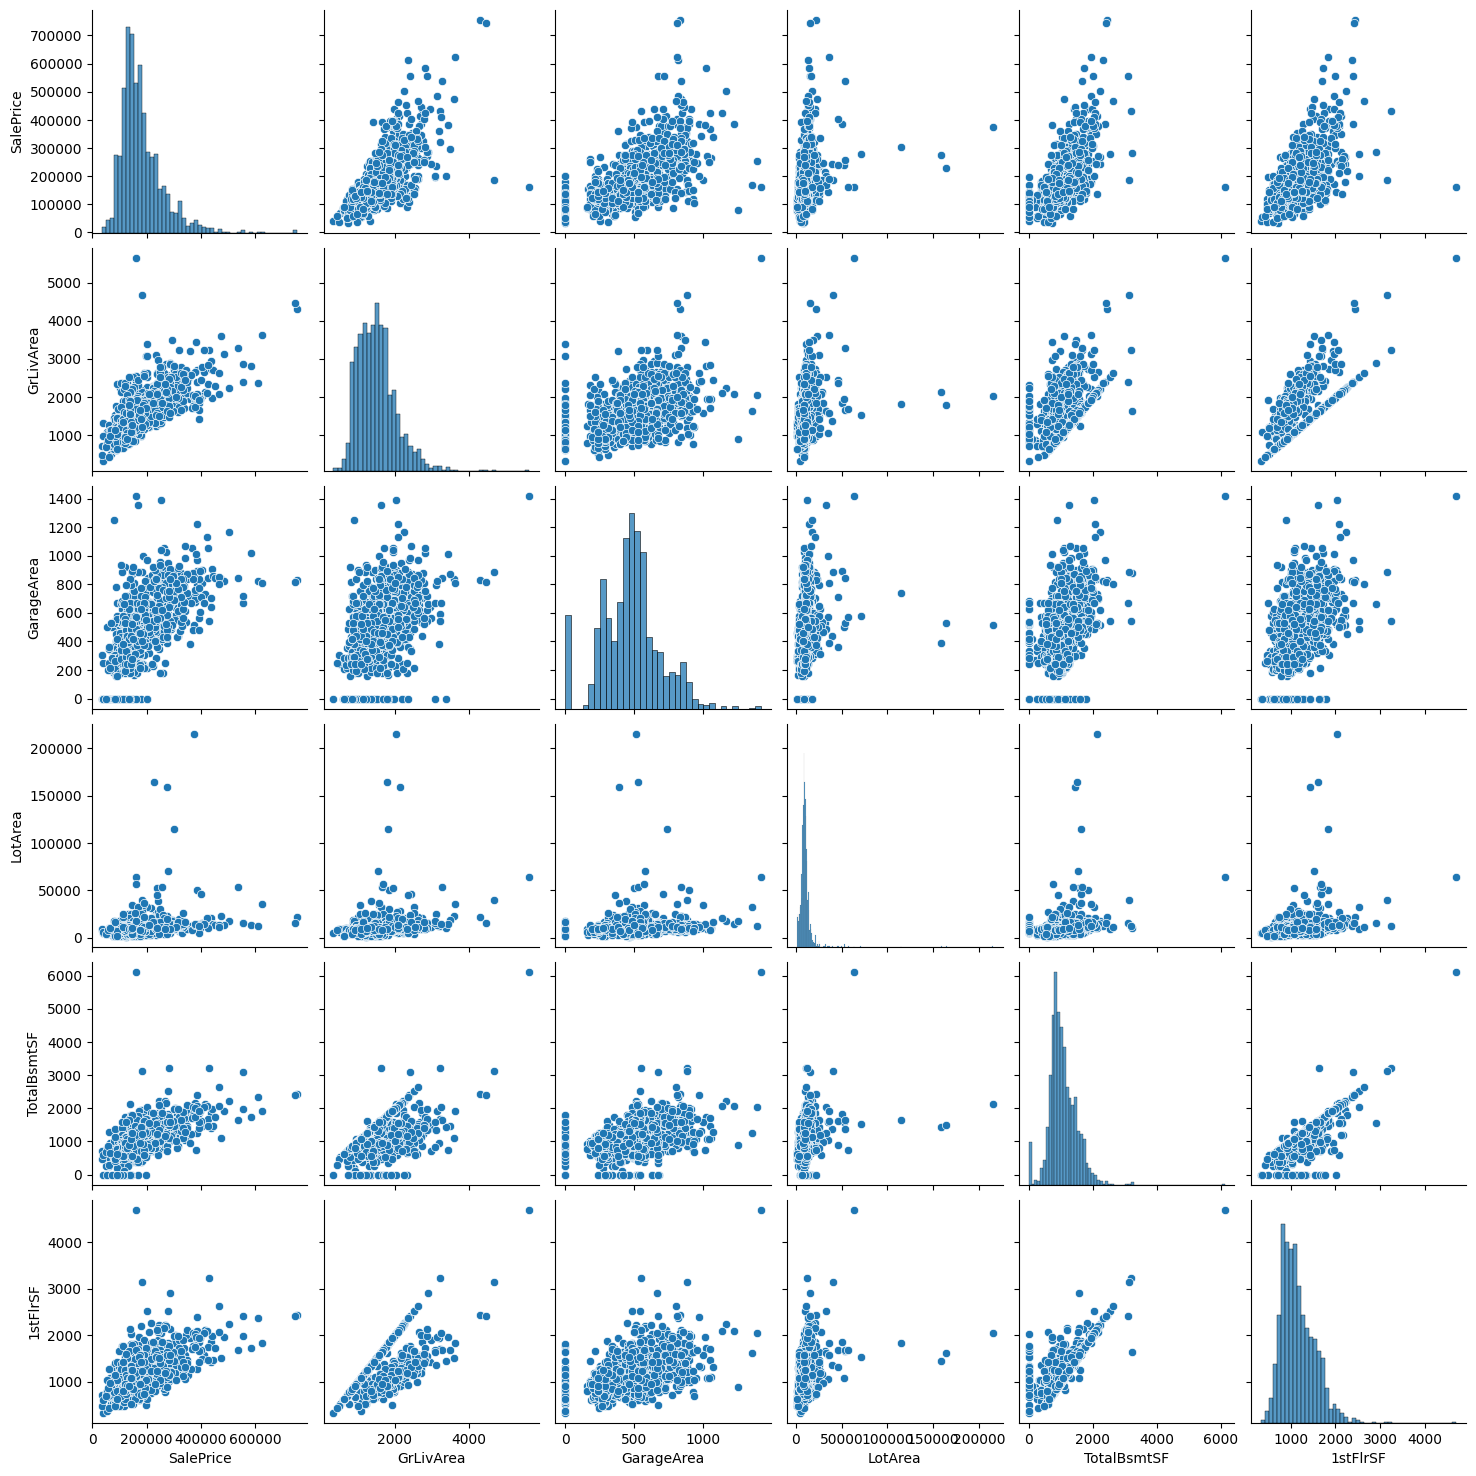

In [18]:
sns.pairplot(quantitative_df[['SalePrice','GrLivArea','GarageArea','LotArea','TotalBsmtSF','1stFlrSF']])